# Feature Engineering

## Variables Description

- **flight_id**: A unique identifier assigned to each flight.
- **date**: The date when the flight took place.
- **callsign**: The encrypted callsign associated with the flight.
- **adep**: The code of the departure airport.
- **name_adep**: The name of the departure airport.
- **country_code_adep**: The country code of the departure airport.
- **ades**: The code of the destination airport.
- **name_ades**: The name of the destination airport.
- **country_code_ades**: The country code of the destination airport.
- **actual_offblock_time**: The time when the aircraft started to move from its parking position.
- **arrival_time**: The time of arrival at the destination airport.
- **aircraft_type**: The type of aircraft used for the flight.
- **wtc**: The wake turbulence category of the aircraft.
- **airline**: The encrypted identifier of the airline operating the flight.
- **flight_duration**: The duration of the flight in minutes.
- **taxiout_time**: The time spent taxiing out from the departure airport.
- **flown_distance**: The distance flown during the flight in kilometers.
- **tow**: The target variable representing the actual TakeOff Weight (TOW) of the aircraft.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from datetime import timedelta
import multiprocessing as mp

In [2]:
# Load the datasets
challenge_set_original = pd.read_csv('./data/challenge_set.csv')
submission_set_original = pd.read_csv('./data/final_submission_set.csv')
# trajectories_set = pd.read_csv('./data/trajectory_features.csv')
trajectories_set_v4 = pd.read_csv('./data/trajectory_features_v6.csv')

# Display the first few rows of the datasets to understand their structure
# challenge_set.T

print('number of samples in the challenge set:', challenge_set_original.shape)
print('number of samples in the submission set:', submission_set_original.shape)
print('total number of samples:', challenge_set_original.shape[0] + submission_set_original.shape[0])

print('number of trajectories:', trajectories_set_v4.shape)

challenge_set = trajectories_set_v4[trajectories_set_v4['flight_id'].isin(challenge_set_original['flight_id'])]
submission_set = trajectories_set_v4[trajectories_set_v4['flight_id'].isin(submission_set_original['flight_id'])]

print('number of samples in the challenge set (with trajectories):', challenge_set.shape)
print('number of samples in the submission set (with trajectories):', submission_set.shape)

number of samples in the challenge set: (369013, 18)
number of samples in the submission set: (158149, 18)
total number of samples: 527162
number of trajectories: (527162, 122)
number of samples in the challenge set (with trajectories): (369013, 122)
number of samples in the submission set (with trajectories): (158149, 122)


In [3]:
challenge_set['wtc'].value_counts()

M    317185
H     51828
Name: wtc, dtype: int64

In [4]:
# Find common columns between challenge_set and trajectories_set_v4
common_columns_challenge = set(challenge_set_original.columns).intersection(set(trajectories_set_v4.columns))
common_columns_submission = set(submission_set_original.columns).intersection(set(trajectories_set_v4.columns))

# Identify missing flight_ids in challenge_set and submission_set
missing_ids_challenge = challenge_set_original[~challenge_set_original['flight_id'].isin(challenge_set['flight_id'])]
missing_ids_submission = submission_set_original[~submission_set_original['flight_id'].isin(submission_set['flight_id'])]

# Extract missing data from trajectories_set_v4
missing_challenge = trajectories_set_v4[trajectories_set_v4['flight_id'].isin(missing_ids_challenge['flight_id'])]
missing_submission = trajectories_set_v4[trajectories_set_v4['flight_id'].isin(missing_ids_submission['flight_id'])]

print("Missing challenge shape:", missing_challenge.shape)
print("Missing submission shape:", missing_submission.shape)

# Verify the number of samples before dropping duplicates
print('Number of samples in the challenge set (with trajectories):', challenge_set.shape)
print('Number of samples in the submission set (with trajectories):', submission_set.shape)

# Assign the updated DataFrames back to challenge_set and submission_set 
challenge_set = challenge_set[~challenge_set.duplicated(keep='first')]
submission_set = submission_set[~submission_set.duplicated(keep='first')]

# Verify the number of samples after dropping duplicates
print('Number of samples in the challenge set (with trajectories, after removing duplicates):', challenge_set.shape)
print('Number of samples in the submission set (with trajectories, after removing duplicates):', submission_set.shape)

Missing challenge shape: (0, 122)
Missing submission shape: (0, 122)
Number of samples in the challenge set (with trajectories): (369013, 122)
Number of samples in the submission set (with trajectories): (158149, 122)
Number of samples in the challenge set (with trajectories, after removing duplicates): (369013, 122)
Number of samples in the submission set (with trajectories, after removing duplicates): (158149, 122)


In [5]:
print(submission_set['flight_id'])

0         248753821
1         248753822
2         248754498
3         248763650
4         248763651
            ...    
158144    258068876
158145    258064675
158146    258065436
158147    258058138
158148    258058370
Name: flight_id, Length: 158149, dtype: int64


In [6]:
print(submission_set_original['flight_id'])

0         248753821
1         248753822
2         248754498
3         248763650
4         248763651
            ...    
158144    258068876
158145    258064675
158146    258065436
158147    258058138
158148    258058370
Name: flight_id, Length: 158149, dtype: int64


In [7]:
submission_set = submission_set.set_index('flight_id')
# submission_set_original = submission_set_original.set_index('flight_id')

submission_set = submission_set.reindex(submission_set_original['flight_id']).reset_index()

In [8]:
print((submission_set['flight_id'] == submission_set_original['flight_id']).sum())

158149


In [9]:
print(submission_set)

        flight_id        date                          callsign  adep  \
0       248753821  2022-01-01  3b3de0f3ad0ee192513995c02f7bf7cf  LTFJ   
1       248753822  2022-01-01  e06dd03d4a879ca37d9e18c1bd7cad16  EBBR   
2       248754498  2022-01-01  2d3b1c962c78c4ebeef11bcd51b9e94c  KMIA   
3       248763650  2022-01-01  35f7721f68bf85128195547ae38b0f04  EBBR   
4       248763651  2022-01-01  eb56918bee9bc5204624186b9bcc4391  LSZH   
...           ...         ...                               ...   ...   
158144  258068876  2022-12-31  c9fca302ca2e28acab0eb0bb1b46f11b  LTFM   
158145  258064675  2022-12-31  00f96ad0e382476649574ba044c764fc  EHAM   
158146  258065436  2022-12-31  87c552b7f6d9bbd16a66e95df761c7f2  LEBL   
158147  258058138  2022-12-31  2cd57e434494606c965bac87c024bda2  LIPE   
158148  258058370  2022-12-31  5f0c222c7f7ceff3fbe75c854cce74c9  UBBB   

                     name_adep country_code_adep  ades  \
0       Istanbul Sabiha Gokcen                TR  LFLL   
1      

In [10]:
# Ensure you are working with a copy of the DataFrame
challenge_set = challenge_set.copy()
submission_set = submission_set.copy()

# Convert 'date' columns to datetime format
challenge_set['date'] = pd.to_datetime(challenge_set['date'])
submission_set['date'] = pd.to_datetime(submission_set['date'])

# Find the min and max dates in both datasets
min_challenge_date = challenge_set['date'].min()
max_challenge_date = challenge_set['date'].max()

min_submission_date = submission_set['date'].min()
max_submission_date = submission_set['date'].max()

(min_challenge_date, max_challenge_date, min_submission_date, max_submission_date)

(Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'))

In [11]:
submission_set.head()

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,specific_energy_5,specific_energy_6,specific_energy_7,specific_energy_8,specific_energy_9,specific_energy_10,kpi17_distance,flown_distance_kpi17,kpi17_time,transit_time_kpi17
0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,2022-01-01T09:44:00Z,...,12163.454345,12326.648145,12408.222551,12408.229409,12408.236267,12408.243126,26663.579690,218345.022835,354.0,1171.0
1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,2022-01-01T09:45:00Z,...,10030.337033,10113.806249,10197.550481,10453.572639,10525.416228,10790.489774,23395.089133,157665.360493,159.0,949.0
2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,2022-01-01T01:52:00Z,...,11247.597982,11777.161725,12015.398326,12015.440576,12527.246029,12800.913110,4237.412941,130614.226266,266.0,747.0
3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,2022-01-01T12:02:00Z,...,9181.242700,9279.018643,9474.418941,9669.824113,9669.963882,9865.511486,126460.177757,302342.488255,613.0,1650.0
4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,2022-01-01T12:03:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,160486.457129,334349.824618,846.0,1983.0


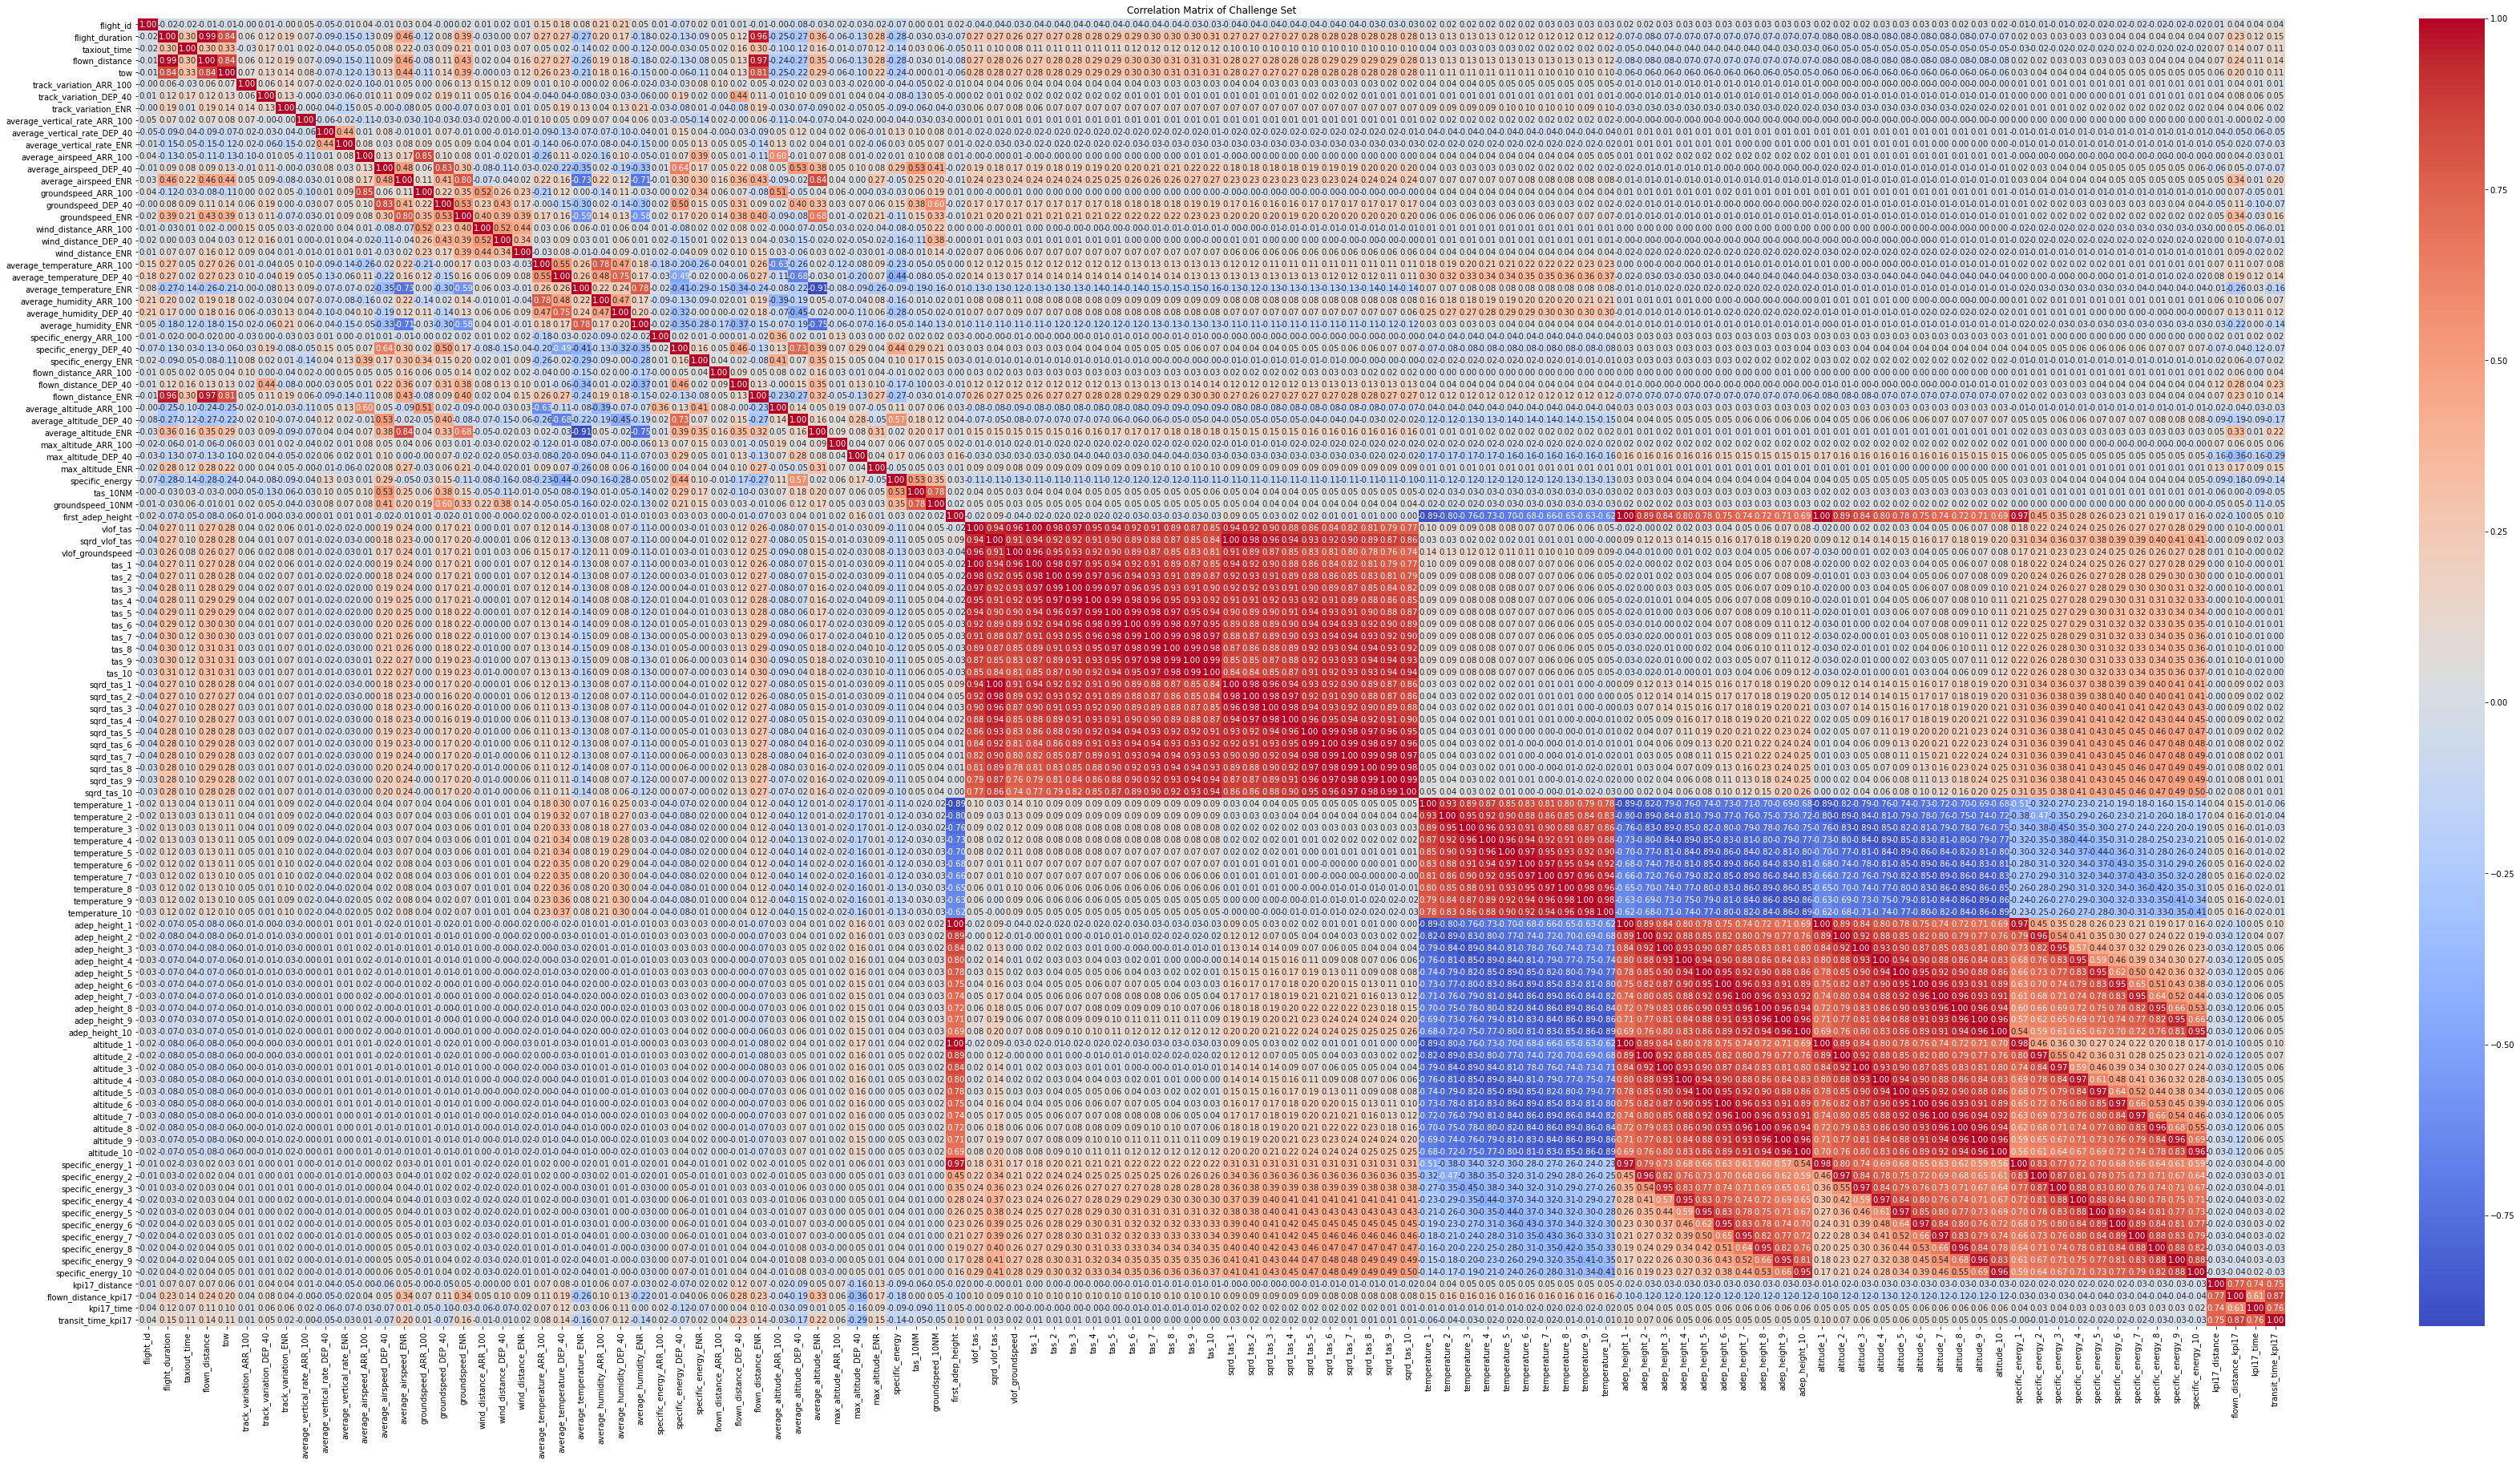

(          flight_id  flight_duration   taxiout_time  flown_distance  \
 count  3.690130e+05    369013.000000  369013.000000   369013.000000   
 mean   2.535220e+08       145.876779      13.489709     1021.728581   
 std    2.688565e+06       139.337587       5.779555     1128.171163   
 min    2.487506e+08         8.000000       0.000000       19.000000   
 25%    2.512296e+08        59.000000      10.000000      338.000000   
 50%    2.536200e+08       100.000000      12.000000      647.000000   
 75%    2.559059e+08       164.000000      16.000000     1113.000000   
 max    2.580745e+08      1013.000000      90.000000     7272.000000   
 
                  tow  track_variation_ARR_100  track_variation_DEP_40  \
 count  369013.000000            353821.000000           357417.000000   
 mean    79482.257229                 3.413526                3.145374   
 std     53250.919631                 2.195837                2.269666   
 min     14944.000000                 0.000000        

In [12]:
# Summary statistics of the challenge set
challenge_summary = challenge_set.describe()

# Check for missing values
missing_values = challenge_set.isnull().sum()

# Drop non-numeric columns before computing the correlation matrix
numeric_challenge_set = challenge_set.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numeric_challenge_set.corr()

# Plotting the correlation matrix
plt.figure(figsize=(60, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# Display the summary statistics and missing values
challenge_summary, missing_values

In [ ]:
# Extract all numerical columns from the dataset
numerical_columns = challenge_set.select_dtypes(include=['number']).columns

# Set the number of plots per row (3 per row for narrow columns)
plots_per_row = 3
total_plots = len(numerical_columns)
rows = (total_plots + plots_per_row - 1) // plots_per_row  # Calculate the required number of rows

# Set up the figure size, adjusting for the number of rows
plt.figure(figsize=(18, rows * 5))  # Adjust the width and height based on rows

for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(rows, plots_per_row, i)  # Arrange the plots in the grid with three plots per row
    
    # Plotting a boxplot for each numerical feature
    sns.boxplot(x=challenge_set[feature], color='skyblue')
    
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(f'{feature}')
    
plt.tight_layout()
plt.show()

In [ ]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = challenge_set['country_code_adep'].unique()
ades_countries = challenge_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries))

In [ ]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = submission_set['country_code_adep'].unique()
ades_countries = submission_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries_sub = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries_sub))

In [ ]:
set(all_countries_sub) - set(all_countries)

In [ ]:
set(all_countries) - set(all_countries_sub)

In [ ]:
challenge_set.iloc[:,45:]

In [ ]:
list(challenge_set.columns)

In [20]:
# Adjusted and expanded extract_time_features function
def extract_time_features(df):
    df = df.copy()
    # Convert datetime strings to datetime objects with error handling
    df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'], errors='coerce')
    df['arrival_time'] = pd.to_datetime(df['arrival_time'], errors='coerce')
    
    # Check for missing datetime values
    missing_offblock = df['actual_offblock_time'].isna().sum()
    missing_arrival = df['arrival_time'].isna().sum()
    print(f"Missing 'actual_offblock_time' values: {missing_offblock}")
    print(f"Missing 'arrival_time' values: {missing_arrival}")
    
    # Handle missing values (decide whether to drop or fill)
    df = df.dropna(subset=['actual_offblock_time', 'arrival_time'])
    
    # Proceed with feature extraction
    df['offblock_hour'] = df['actual_offblock_time'].dt.hour
    df['offblock_minute'] = df['actual_offblock_time'].dt.minute
    df['offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
    df['offblock_day_of_year'] = df['actual_offblock_time'].dt.dayofyear
    df['offblock_month'] = df['actual_offblock_time'].dt.month
    df['offblock_week_of_year'] = df['actual_offblock_time'].dt.isocalendar().week.astype(int)
    df['offblock_quarter'] = df['actual_offblock_time'].dt.quarter
    df['offblock_year'] = df['actual_offblock_time'].dt.year
    df['offblock_season'] = df['offblock_month'].apply(
        lambda x: 'Winter' if x in [12, 1, 2] else 
                  'Spring' if x in [3, 4, 5] else
                  'Summer' if x in [6, 7, 8] else 'Fall'
    )
    df['offblock_weekday_name'] = df['actual_offblock_time'].dt.day_name()
    
    # Extract time features from 'arrival_time'
    df['arrival_hour'] = df['arrival_time'].dt.hour
    df['arrival_minute'] = df['arrival_time'].dt.minute
    df['arrival_day_of_week'] = df['arrival_time'].dt.dayofweek
    df['arrival_day_of_year'] = df['arrival_time'].dt.dayofyear
    df['arrival_month'] = df['arrival_time'].dt.month
    df['arrival_week_of_year'] = df['arrival_time'].dt.isocalendar().week.astype(int)
    df['arrival_quarter'] = df['arrival_time'].dt.quarter
    df['arrival_year'] = df['arrival_time'].dt.year
    df['arrival_season'] = df['arrival_month'].apply(
        lambda x: 'Winter' if x in [12, 1, 2] else 
                  'Spring' if x in [3, 4, 5] else
                  'Summer' if x in [6, 7, 8] else 'Fall'
    )
    df['arrival_weekday_name'] = df['arrival_time'].dt.day_name()
    
    # Calculate the duration in minutes between offblock and arrival
    df['offblock_to_arrival_duration'] = (df['arrival_time'] - df['actual_offblock_time']).dt.total_seconds() / 60
    
    # Add boolean flags for weekends and rush hours
    df['is_offblock_weekend'] = df['offblock_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_offblock_rush_hour'] = df['offblock_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)
    df['is_arrival_weekend'] = df['arrival_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_arrival_rush_hour'] = df['arrival_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)
    
    # Calculate time difference in days
    df['offblock_to_arrival_day_diff'] = (df['arrival_time'] - df['actual_offblock_time']).dt.days
    
    return df

# create_duration_features function
def create_duration_features(df):
    df = df.copy()
    # Replace zero or negative values in flight_duration to avoid division errors
    df['flight_duration'] = df['flight_duration'].replace(0, np.nan)
    df['taxiout_time'] = df['taxiout_time'].replace(0, np.nan)
    
    # Fill NaN values in taxiout_time with the median or a reasonable default
    df['taxiout_time'] = df['taxiout_time'].fillna(df['taxiout_time'].median())
    
    # Calculate the ratio of taxiout time to flight duration
    df['taxi_ratio'] = df['taxiout_time'] / df['flight_duration']
    df['taxi_ratio'] = df['taxi_ratio'].fillna(df['taxi_ratio'].median())
    
    # Calculate the average flight speed (distance per minute)
    df['flight_speed'] = df['flown_distance'] / df['flight_duration']
    df['flight_speed'] = df['flight_speed'].replace([np.inf, -np.inf], np.nan)
    df['flight_speed'] = df['flight_speed'].fillna(df['flight_speed'].median())
    
    # Normalize taxi_ratio by the median value
    df['normalized_taxi_ratio'] = df['taxi_ratio'] / df['taxi_ratio'].median()
    
    # Categorical features for flight duration buckets
    df['flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 60, 180, 300, np.inf], 
                                            labels=['Very Short', 'Short', 'Medium', 'Long'], right=False)
    
    # Speed per distance feature
    df['speed_per_distance'] = df['flight_speed'] / df['flown_distance']
    df['speed_per_distance'] = df['speed_per_distance'].replace([np.inf, -np.inf], np.nan)
    df['speed_per_distance'] = df['speed_per_distance'].fillna(df['speed_per_distance'].median())
    
    # Cumulative mean of flight speed
    df['cumulative_avg_speed'] = df['flight_speed'].expanding().mean()
    
    # Additional features
    # Average speed during the Enroute phase
    df['avg_speed_ENR'] = df['flown_distance_ENR'] / (df['flight_duration'] - df['taxiout_time'])
    df['avg_speed_ENR'] = df['avg_speed_ENR'].replace([np.inf, -np.inf], np.nan)
    df['avg_speed_ENR'] = df['avg_speed_ENR'].fillna(df['avg_speed_ENR'].median())
    
    # Ratio of Enroute distance to total flown distance
    df['ENR_distance_ratio'] = df['flown_distance_ENR'] / df['flown_distance']
    df['ENR_distance_ratio'] = df['ENR_distance_ratio'].replace([np.inf, -np.inf], np.nan)
    df['ENR_distance_ratio'] = df['ENR_distance_ratio'].fillna(df['ENR_distance_ratio'].median())
    
    # Flight time excluding taxiout_time
    df['flight_time_excl_taxi'] = df['flight_duration'] - df['taxiout_time']
    
    return df

# group_airports_by_region function
def group_airports_by_region(df):
    df = df.copy()
    # Define country groups for regions
    europe_countries = ['GB', 'FR', 'DE', 'ES', 'IT', 'SE', 'CH', 'NL', 'AT', 'IE', 'BE', 'DK', 'FI', 'GR', 'HU', 
                        'IS', 'LT', 'LU', 'LV', 'MT', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'CZ', 'EE', 'BG', 'CY']
    north_america_countries = ['US', 'CA', 'MX']
    south_america_countries = ['BR', 'AR', 'CL', 'CO', 'PE', 'VE', 'UY', 'PY', 'BO', 'EC', 'GY', 'SR']
    middle_east_countries = ['AE', 'SA', 'IL', 'IR', 'IQ', 'JO', 'KW', 'OM', 'QA', 'BH', 'LB', 'SY', 'YE']
    asia_countries = ['JP', 'CN', 'KR', 'IN', 'PK', 'BD', 'VN', 'PH', 'TH', 'MY', 'ID', 'SG', 'MN', 'KZ', 'TM', 'UZ', 'KG']
    africa_countries = ['ZA', 'NG', 'EG', 'DZ', 'MA', 'KE', 'TZ', 'GH', 'ET', 'CI', 'SN', 'SD', 'AO', 'LR', 'RW', 'ER']
    oceania_countries = ['AU', 'NZ', 'FJ', 'PG']
    
    # Get the set of other countries present in the dataset
    all_countries = set(df['country_code_adep'].unique()).union(set(df['country_code_ades'].unique()))
    known_countries = set(europe_countries + north_america_countries + south_america_countries + 
                          middle_east_countries + asia_countries + africa_countries + oceania_countries)
    other_countries = all_countries - known_countries
    
    # Apply region categorization based on country codes
    def categorize_region(code):
        if code in europe_countries:
            return 'Europe'
        elif code in north_america_countries:
            return 'North America'
        elif code in south_america_countries:
            return 'South America'
        elif code in middle_east_countries:
            return 'Middle East'
        elif code in asia_countries:
            return 'Asia'
        elif code in africa_countries:
            return 'Africa'
        elif code in oceania_countries:
            return 'Oceania'
        elif code in other_countries:
            return 'Other'
        else:
            return 'Unknown'
    
    # Apply region classification for adep and ades
    df['adep_region'] = df['country_code_adep'].apply(categorize_region)
    df['ades_region'] = df['country_code_ades'].apply(categorize_region)
    
    return df

# Adjusted and expanded extract_country_features function
def extract_country_features(df):
    df = df.copy()
    # Basic feature indicating if the flight is within the same country
    df['same_country_flight'] = (df['country_code_adep'] == df['country_code_ades']).astype(int)
    
    # Feature indicating if the flight is within the same region
    df['same_region_flight'] = (df['adep_region'] == df['ades_region']).astype(int)
    
    # Flight direction based on regions
    def determine_flight_direction(row):
        if row['adep_region'] == 'North America' and row['ades_region'] == 'South America':
            return 'North_to_South'
        elif row['adep_region'] == 'Europe' and row['ades_region'] == 'Asia':
            return 'West_to_East'
        elif row['adep_region'] == 'Asia' and row['ades_region'] == 'Europe':
            return 'East_to_West'
        else:
            return 'Other'
    
    df['flight_direction'] = df.apply(determine_flight_direction, axis=1)
    
    # Create a feature indicating if the flight is intercontinental
    intercontinental_regions = ['Europe', 'North America', 'South America', 'Middle East', 'Asia', 'Africa', 'Oceania']
    df['is_intercontinental'] = df.apply(
        lambda row: 1 if row['adep_region'] in intercontinental_regions and 
                         row['ades_region'] in intercontinental_regions and 
                         row['adep_region'] != row['ades_region'] else 0, axis=1)
    
    return df

# Adjusted and expanded create_interactions function
def create_interactions(df):
    df = df.copy()
    # Create interaction features between airspeed and specific energy for different flight phases
    df['airspeed_specific_energy_ARR'] = df['average_airspeed_ARR_100'] * df['specific_energy_ARR_100']
    df['airspeed_specific_energy_DEP'] = df['average_airspeed_DEP_40'] * df['specific_energy_DEP_40']
    df['airspeed_specific_energy_ENR'] = df['average_airspeed_ENR'] * df['specific_energy_ENR']
    
    # Additional interactions: groundspeed and flown distance
    df['groundspeed_flown_distance_ARR'] = df['groundspeed_ARR_100'] * df['flown_distance_ARR_100']
    df['groundspeed_flown_distance_DEP'] = df['groundspeed_DEP_40'] * df['flown_distance_DEP_40']
    df['groundspeed_flown_distance_ENR'] = df['groundspeed_ENR'] * df['flown_distance_ENR']
    
    # Interaction between humidity and temperature
    df['humidity_temperature_ARR'] = df['average_humidity_ARR_100'] * df['average_temperature_ARR_100']
    df['humidity_temperature_DEP'] = df['average_humidity_DEP_40'] * df['average_temperature_DEP_40']
    df['humidity_temperature_ENR'] = df['average_humidity_ENR'] * df['average_temperature_ENR']
    
    # Interaction between vertical rate and airspeed
    df['vertical_rate_airspeed_ARR'] = df['average_vertical_rate_ARR_100'] * df['average_airspeed_ARR_100']
    df['vertical_rate_airspeed_DEP'] = df['average_vertical_rate_DEP_40'] * df['average_airspeed_DEP_40']
    df['vertical_rate_airspeed_ENR'] = df['average_vertical_rate_ENR'] * df['average_airspeed_ENR']
    
    # Interaction between altitude and groundspeed
    df['altitude_groundspeed_ARR'] = df['average_altitude_ARR_100'] * df['groundspeed_ARR_100']
    df['altitude_groundspeed_DEP'] = df['average_altitude_DEP_40'] * df['groundspeed_DEP_40']
    df['altitude_groundspeed_ENR'] = df['average_altitude_ENR'] * df['groundspeed_ENR']
    
    return df

# Adjusted and expanded create_bins function
def create_bins(df):
    df = df.copy()
    # Create bins (discretization) for temperature and humidity into 5 categories
    df['temperature_bins_ARR'] = pd.qcut(df['average_temperature_ARR_100'], q=5, labels=False, duplicates='drop')
    df['temperature_bins_DEP'] = pd.qcut(df['average_temperature_DEP_40'], q=5, labels=False, duplicates='drop')
    df['humidity_bins_ARR'] = pd.qcut(df['average_humidity_ARR_100'], q=5, labels=False, duplicates='drop')
    df['humidity_bins_DEP'] = pd.qcut(df['average_humidity_DEP_40'], q=5, labels=False, duplicates='drop')
    
    # Create bins for vertical rate
    df['vertical_rate_bins_ARR'] = pd.qcut(df['average_vertical_rate_ARR_100'], q=5, labels=False, duplicates='drop')
    df['vertical_rate_bins_DEP'] = pd.qcut(df['average_vertical_rate_DEP_40'], q=5, labels=False, duplicates='drop')
    
    # Create bins for flight duration
    df['flight_duration_bins'] = pd.qcut(df['flight_duration'], q=5, labels=False, duplicates='drop')
    
    # Create bins for flown distance
    df['flown_distance_bins'] = pd.qcut(df['flown_distance'], q=5, labels=False, duplicates='drop')
    
    return df

# Adjusted and expanded create_ratios function
def create_ratios(df):
    df = df.copy()
    # Create ratio features such as vertical rate to airspeed for arrival and departure phases
    df['vertical_rate_airspeed_ratio_ARR'] = df['average_vertical_rate_ARR_100'] / df['average_airspeed_ARR_100']
    df['vertical_rate_airspeed_ratio_DEP'] = df['average_vertical_rate_DEP_40'] / df['average_airspeed_DEP_40']
    df['vertical_rate_airspeed_ratio_ENR'] = df['average_vertical_rate_ENR'] / df['average_airspeed_ENR']
    
    # Additional ratios: wind distance over flown distance
    df['wind_distance_flown_distance_ARR'] = df['wind_distance_ARR_100'] / df['flown_distance_ARR_100']
    df['wind_distance_flown_distance_DEP'] = df['wind_distance_DEP_40'] / df['flown_distance_DEP_40']
    df['wind_distance_flown_distance_ENR'] = df['wind_distance_ENR'] / df['flown_distance_ENR']
    
    # Ratios of groundspeed to airspeed
    df['groundspeed_airspeed_ratio_ARR'] = df['groundspeed_ARR_100'] / df['average_airspeed_ARR_100']
    df['groundspeed_airspeed_ratio_DEP'] = df['groundspeed_DEP_40'] / df['average_airspeed_DEP_40']
    df['groundspeed_airspeed_ratio_ENR'] = df['groundspeed_ENR'] / df['average_airspeed_ENR']
    
    # Replace infinite and NaN values
    ratio_columns = [
        'vertical_rate_airspeed_ratio_ARR', 'vertical_rate_airspeed_ratio_DEP', 'vertical_rate_airspeed_ratio_ENR',
        'wind_distance_flown_distance_ARR', 'wind_distance_flown_distance_DEP', 'wind_distance_flown_distance_ENR',
        'groundspeed_airspeed_ratio_ARR', 'groundspeed_airspeed_ratio_DEP', 'groundspeed_airspeed_ratio_ENR'
    ]
    for col in ratio_columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        df[col] = df[col].fillna(df[col].median())
    
    return df

# Function to remove original columns after feature extraction
def remove_columns(df, columns_to_remove):
    # Remove original columns since features have been extracted
    df = df.drop(columns_to_remove, axis=1)
    return df

# Updated list of columns to remove after feature extraction
columns_to_remove = [
    'name_adep', 'name_ades', 'country_code_adep', 'country_code_ades', 'flight_id', 
    'actual_offblock_time', 'arrival_time', 'flight_duration'
]

# Apply all functions to the challenge set
challenge_set = challenge_set.copy()
cleaned_challenge_set = extract_time_features(challenge_set)
print("extract_time_features completed")

cleaned_challenge_set = create_duration_features(cleaned_challenge_set)
print("create_duration_features completed")

cleaned_challenge_set = group_airports_by_region(cleaned_challenge_set)
print("group_airports_by_region completed")

cleaned_challenge_set = extract_country_features(cleaned_challenge_set)
print("extract_country_features completed")

cleaned_challenge_set = create_interactions(cleaned_challenge_set)
print("create_interactions completed")

cleaned_challenge_set = create_bins(cleaned_challenge_set)
print("create_bins completed")

cleaned_challenge_set = create_ratios(cleaned_challenge_set)
print("create_ratios completed")

cleaned_challenge_set = remove_columns(cleaned_challenge_set, columns_to_remove)
print("remove_columns completed")

# Apply all functions to the submission set
submission_set = submission_set.copy()
cleaned_submission_set = extract_time_features(submission_set)
print("extract_time_features completed on submission_set")

cleaned_submission_set = create_duration_features(cleaned_submission_set)
print("create_duration_features completed on submission_set")

cleaned_submission_set = group_airports_by_region(cleaned_submission_set)
print("group_airports_by_region completed on submission_set")

cleaned_submission_set = extract_country_features(cleaned_submission_set)
print("extract_country_features completed on submission_set")

cleaned_submission_set = create_interactions(cleaned_submission_set)
print("create_interactions completed on submission_set")

cleaned_submission_set = create_bins(cleaned_submission_set)
print("create_bins completed on submission_set")

cleaned_submission_set = create_ratios(cleaned_submission_set)
print("create_ratios completed on submission_set")

# Reordering the rows of the submission set
cleaned_submission_set = cleaned_submission_set.set_index('flight_id')
cleaned_submission_set = cleaned_submission_set.reindex(submission_set_original['flight_id']).reset_index()

cleaned_submission_set = remove_columns(cleaned_submission_set, columns_to_remove)
print("remove_columns completed on submission_set")

# Display the transposed first few rows of the updated challenge set for review
# cleaned_challenge_set.head().T
cleaned_submission_set.head()

extract_country_features completed
create_interactions completed
create_bins completed
create_ratios completed
remove_columns completed
Missing 'actual_offblock_time' values: 0
Missing 'arrival_time' values: 0
extract_time_features completed on submission_set
create_duration_features completed on submission_set
group_airports_by_region completed on submission_set
extract_country_features completed on submission_set
create_interactions completed on submission_set
create_bins completed on submission_set
create_ratios completed on submission_set
remove_columns completed on submission_set


,date,callsign,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,tow,...,flown_distance_bins,vertical_rate_airspeed_ratio_ARR,vertical_rate_airspeed_ratio_DEP,vertical_rate_airspeed_ratio_ENR,wind_distance_flown_distance_ARR,wind_distance_flown_distance_DEP,wind_distance_flown_distance_ENR,groundspeed_airspeed_ratio_ARR,groundspeed_airspeed_ratio_DEP,groundspeed_airspeed_ratio_ENR
0,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,LFLL,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,15.0,1122,NaN,...,3,-8.020114,15.020886,0.220199,-0.030711,-0.029932,-0.039698,0.973918,0.971822,0.961883
1,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,KJFK,A333,H,bdeeef3a675587d530de70a25d7118d2,15.0,3205,NaN,...,4,-6.845727,10.805256,0.199599,-0.119909,-0.053758,-0.104531,0.901776,0.949075,0.910287
2,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,EGLL,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,10.0,3965,NaN,...,4,-7.304139,13.401962,1.117148,0.099652,-0.000723,0.178677,1.110259,0.999289,1.150413
3,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,LEAL,B738,M,f53c55b5cf0cbb3be755bf50df6fa52d,9.0,802,NaN,...,2,-8.812356,16.296394,0.280370,-0.021276,-0.113165,-0.048885,0.979202,0.898337,0.953418
4,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,LFPG,BCS3,M,2d5def0a5a844b343ba1b7cc9cb28fa9,11.0,292,NaN,...,0,-7.629575,15.364139,0.979014,-0.020962,-0.050592,-0.053596,0.979482,0.951945,0.949247


In [21]:
# Extracting unique aircraft types from each set
challenge_aircraft_types = set(challenge_set['aircraft_type'].unique())
submission_aircraft_types = set(submission_set['aircraft_type'].unique())

# Aircraft types in challenge_set but not in submission_set
only_in_challenge = challenge_aircraft_types - submission_aircraft_types
print("Aircraft types only in challenge_set:", only_in_challenge)

# Aircraft types in submission_set but not in challenge_set
only_in_submission = submission_aircraft_types - challenge_aircraft_types
print("Aircraft types only in submission_set:", only_in_submission)

Aircraft types only in challenge_set: {'C56X', 'A310'}
Aircraft types only in submission_set: set()


In [22]:
!pip install openpyxl

# Load the FAA Aircraft Characteristics Database from the uploaded Excel file
file_path = "./extra_data/FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07.xlsx"

# Load the FAA dataset and select relevant columns
faa_data = pd.read_excel(file_path, sheet_name='ACD_Data')

# Select relevant columns for merging
faa_relevant_columns = [
    'FAA_Designator', 'MTOW_lb', 'MALW_lb', 'Manufacturer', 'Model_FAA',
    'Physical_Class_Engine', 'Num_Engines', 'Approach_Speed_knot', 
    'FAA_Weight'
]

# Prepare the FAA data for merging
faa_clean = faa_data[faa_relevant_columns].copy()  # Use .copy() to avoid the warning

# Convert MTOW and MALW from pounds to kilograms for consistency
faa_clean.loc[:, 'MTOW_kg'] = faa_clean['MTOW_lb'] * 0.453592
faa_clean.loc[:, 'MALW_kg'] = faa_clean['MALW_lb'] * 0.453592

# Merge the cleaned_challenge_set with FAA data on aircraft_type and FAA_Designator
cleaned_challenge_set = cleaned_challenge_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Merge the cleaned_submission_set with FAA data on aircraft_type and FAA_Designator
cleaned_submission_set = cleaned_submission_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Drop unnecessary columns
cleaned_challenge_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)
cleaned_submission_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)

# Display the transposed cleaned_challenge_set for review
cleaned_challenge_set.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,3840d84f25d3f5fcc0a1be3076bb4039,f6f610e73002b8892a239a81321f7f1d,139670936660762c230ca92556ba842b,509dc61bb54fbab0e5406067c95603e2,d0610d000dcf26b1d7bba8103ecc393d,e6d5d070016d21108f8bd2bd643202ac,1f51e76bb1001c4f9de991288aacb326,52d1b50f92590b36489a929375be10f6,256265f000acb4a06cd680b3df7c9897,8191fa049d6f1a6cb432a98d97bf960c,...,5ea802e68573752dc98d7623d897a915,b1de87e85987c58b0d29fa4e72e3f961,49c815d2ca2e8c50b01473b12fd30119,92eba53fed3c3914105be1de666ca203,80e0832fdc79cbba84dff5e9e06bb883,85ee68e5b7b5acf24ba00d1318eca1e8,570cf7d5ebbd691bcba63e7466607da7,5a7e43e4f981539ae3d3b1cb31591b7c,a1c078516f9f9e90cacec61854cad45b,6c98fcaa191dec632b87b46511f1d2da
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Num_Engines,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Approach_Speed_knot,136.0,140.0,137.0,144.0,136.0,137.0,136.0,144.0,144.0,142.0,...,136.0,136.0,142.0,136.0,135.0,144.0,136.0,136.0,136.0,140.0
FAA_Weight,Large,Heavy,Heavy,Heavy,Large,Large,Large,Large,Heavy,Large,...,Large,Large,Large,Large,Large,Heavy,Large,Large,Large,Heavy
MTOW_kg,78000.133912,297556.352,241999.950248,227929.98,94999.854888,78999.85068,78000.133912,79015.7264,254011.52,91000.080632,...,78000.133912,94999.854888,91000.080632,78000.133912,52290.08576,227929.98,94999.854888,78000.133912,94999.854888,297556.352


In [23]:
cleaned_submission_set['wtc'].value_counts()

M    135837
H     22312
Name: wtc, dtype: int64

In [24]:
cleaned_submission_set['Physical_Class_Engine'].value_counts()

Jet          155172
Turboprop      2977
Name: Physical_Class_Engine, dtype: int64

In [25]:
cleaned_challenge_set['wtc'].value_counts()

M    317185
H     51828
Name: wtc, dtype: int64

In [26]:
cleaned_challenge_set['Physical_Class_Engine'].value_counts()

Jet          362116
Turboprop      6897
Name: Physical_Class_Engine, dtype: int64

In [27]:
list(cleaned_challenge_set.columns)


['date',
 'callsign',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_40',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_40',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_40',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_40',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_40',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_40',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_40',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_40',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_40',
 'flown_distance_ENR',
 'average_altitude_ARR_100',
 'average_altitude_DEP_40',
 'average_altitude_ENR',
 'max_altitude_ARR_100',
 'max_altitude_DEP_40',
 'max_altitude_ENR',


In [28]:
# Function to classify aircraft based on wtc and Physical_Class_Engine
def classify_aircraft(row):
    if row['Physical_Class_Engine'] == 'Turboprop' and row['wtc'] == 'M':
        return 'Medium Turbo Prop'
    elif row['Physical_Class_Engine'] == 'Jet' and row['wtc'] == 'M':
        return 'Medium Jet'
    elif row['Physical_Class_Engine'] == 'Jet' and row['wtc'] == 'H':
        return 'Heavy Jet'
    else:
        return None  # If no classification applies, return None

# Apply the function to both dataframes
cleaned_challenge_set['Aircraft_Class'] = cleaned_challenge_set.apply(classify_aircraft, axis=1)
cleaned_submission_set['Aircraft_Class'] = cleaned_submission_set.apply(classify_aircraft, axis=1)

# Check for any unclassified rows in challenge_set
unclassified_challenge = cleaned_challenge_set[cleaned_challenge_set['Aircraft_Class'].isnull()]
if not unclassified_challenge.empty:
    print("There are unclassified rows in challenge_set:")
    print(unclassified_challenge)

# Check for any unclassified rows in submission_set
unclassified_submission = cleaned_submission_set[cleaned_submission_set['Aircraft_Class'].isnull()]
if not unclassified_submission.empty:
    print("There are unclassified rows in submission_set:")
    print(unclassified_submission)

# Check if the class types in both dataframes are aligned
classes_challenge_set = set(cleaned_challenge_set['Aircraft_Class'].dropna().unique())
classes_submission_set = set(cleaned_submission_set['Aircraft_Class'].dropna().unique())

if classes_challenge_set == classes_submission_set:
    print("The class types are aligned!")
else:
    print("The class types are not aligned!")
    print(f"Class types in challenge_set: {classes_challenge_set}")
    print(f"Class types in submission_set: {classes_submission_set}")

The class types are aligned!


In [29]:
list(cleaned_challenge_set.columns)

['date',
 'callsign',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_40',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_40',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_40',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_40',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_40',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_40',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_40',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_40',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_40',
 'flown_distance_ENR',
 'average_altitude_ARR_100',
 'average_altitude_DEP_40',
 'average_altitude_ENR',
 'max_altitude_ARR_100',
 'max_altitude_DEP_40',
 'max_altitude_ENR',


In [30]:
# Check for unique aircraft types in the cleaned challenge set
unique_aircraft_types = cleaned_challenge_set['aircraft_type'].unique()

# Check which aircraft types from the challenge set are not present in the FAA data
missing_aircraft_types = [atype for atype in unique_aircraft_types if atype not in faa_data['FAA_Designator'].unique()]

missing_aircraft_types

[]

In [31]:
# Including extra features for the aircraft
aircraft_extra = pd.read_csv('./extra_data/aircraft_extra_v3.csv')

# Merge the cleaned_challenge_set with aircraft_extra
cleaned_challenge_set = cleaned_challenge_set.merge(
    aircraft_extra, how='left', left_on='aircraft_type', right_on='aircraft_type'
)

# Merge the cleaned_submission_set with aircraft_extra
cleaned_submission_set = cleaned_submission_set.merge(
    aircraft_extra, how='left', left_on='aircraft_type', right_on='aircraft_type'
)

In [32]:
# Load the GlobalAirportDatabase.txt into a DataFrame
columns_global = ['ICAO', 'IATA', 'Airport Name', 'City/Town', 'Country', 
                  'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds', 'Latitude Direction',
                  'Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds', 'Longitude Direction',
                  'Altitude', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees']
global_airports = pd.read_csv('./extra_data/GlobalAirportDatabase.txt', sep=':', header=None, names=columns_global)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
global_airports = global_airports[['ICAO', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees', 'Altitude']]

# Load the airports.dat file (assuming previous naming and structure)
columns_openflights = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 
                       'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 
                       'Type', 'Source']
openflights_airports = pd.read_csv('./extra_data/airports.dat', header=None, names=columns_openflights)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
openflights_airports = openflights_airports[['ICAO', 'Latitude', 'Longitude', 'Altitude']]
openflights_airports.rename(columns={'Latitude': 'Latitude Decimal Degrees', 
                                     'Longitude': 'Longitude Decimal Degrees'}, inplace=True)

# Concatenate both datasets, removing duplicates based on ICAO codes
airports = pd.concat([global_airports, openflights_airports]).drop_duplicates(subset=['ICAO'])

# Display the combined dataset to verify the merge
airports.head()

,ICAO,Latitude Decimal Degrees,Longitude Decimal Degrees,Altitude
0,AYGA,-6.082,145.392,1610
1,AYLA,0.000,0.000,0
2,AYMD,-5.207,145.789,7
3,AYMH,-5.826,144.296,1643
4,AYNZ,-6.570,146.726,73


In [33]:
# Backup
backup_challenge_set = cleaned_challenge_set.copy()

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports

# Merge for adep (departure airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

# Display the transposed DataFrame to confirm the correct columns are retained
cleaned_challenge_set.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,3840d84f25d3f5fcc0a1be3076bb4039,f6f610e73002b8892a239a81321f7f1d,139670936660762c230ca92556ba842b,509dc61bb54fbab0e5406067c95603e2,d0610d000dcf26b1d7bba8103ecc393d,e6d5d070016d21108f8bd2bd643202ac,1f51e76bb1001c4f9de991288aacb326,52d1b50f92590b36489a929375be10f6,256265f000acb4a06cd680b3df7c9897,8191fa049d6f1a6cb432a98d97bf960c,...,5ea802e68573752dc98d7623d897a915,b1de87e85987c58b0d29fa4e72e3f961,49c815d2ca2e8c50b01473b12fd30119,92eba53fed3c3914105be1de666ca203,80e0832fdc79cbba84dff5e9e06bb883,85ee68e5b7b5acf24ba00d1318eca1e8,570cf7d5ebbd691bcba63e7466607da7,5a7e43e4f981539ae3d3b1cb31591b7c,a1c078516f9f9e90cacec61854cad45b,6c98fcaa191dec632b87b46511f1d2da
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,25.0,4.0,38.0,432.0,74.0,208.0,5.0,325.0,39.0,325.0,...,4.0,25.0,325.0,432.0,56.0,120.0,325.0,45.0,120.0,610.0
ICAO_ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
Latitude_ades,51.843,25.793,41.979,39.872,51.477,38.282,51.477,44.818,41.275278,40.128,...,50.902,47.465,45.631,40.52,48.11,25.793,52.38,53.421,53.421,40.64
Longitude_ades,-8.492,-80.291,-87.904,-75.241,-0.461,-0.558,-0.461,20.309,28.751944,32.995,...,4.499,8.549,8.728,22.971,16.57,-80.291,13.523,-6.27,-6.27,-73.779


In [34]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = cleaned_challenge_set.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = cleaned_challenge_set[cleaned_challenge_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = cleaned_challenge_set[cleaned_challenge_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(9, {'HSSK', 'LFTM', 'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'})

In [35]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = cleaned_challenge_set[cleaned_challenge_set.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values.T

,5,10,11,14,23,25,28,30,31,32,...,368986,368987,368988,368989,368993,368994,368998,369000,369009,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,e6d5d070016d21108f8bd2bd643202ac,9dbac4d61a4c3178948c0df9b4437643,b82d5d608896f78826fe00e6fb510cec,6b73a2e94f26ee2be7fae1385f7f56ce,d1a95c2c0a43c34472b5559c55bab3c2,1104b47ca1b186d446583663049a4997,e55a172b6484d4912bc42fa67e929e30,12f206cf334575a41f37c1aee6a9d549,faf0a65c0b2f2d499ea3769e7b5360b8,d802eab47fb17ed5c8398da34e960088,...,9437d01aa51e970bcc9312aea9d1f3bd,cb5eeaf81dfdfe9eb8ff89d7d93ecb55,ec9d0f6996c4ad9ace131aafd71afce3,60e37f7881ab9d33b65ae8e0d39d7b4e,3efea6c1bd348013aecdcda1aabafcd0,efaf387673f0f563093865d6123308e0,2a7545bbf682b1920acfdcfef21865f9,a5d85efe882e6700e3e60d32a4f5fd8b,570cf7d5ebbd691bcba63e7466607da7,6c98fcaa191dec632b87b46511f1d2da
adep,ENGM,LOWW,LSZH,LTAT,EGPF,KCLT,EDDF,EBBR,LSZH,LTFM,...,EDDF,EBBR,LIMC,EBBR,LOWW,LSZH,EBBR,LTFM,LTFM,LEMD
ades,LEAL,EDDM,ESGG,LTAC,EIDW,EGLL,EKCH,LIMC,KSFO,KATL,...,KCLT,EGLL,LOWW,EGCC,LLBG,EGLL,LIPZ,LEBL,EDDB,KJFK
aircraft_type,A20N,A320,A320,B738,A320,B772,CRJ9,A319,B77W,B789,...,B772,A320,E195,A320,A321,A20N,A320,A21N,A21N,B772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,208.0,183.0,432.0,862.0,8.0,229.0,111.0,57.0,432.0,325.0,...,111.0,57.0,234.0,57.0,183.0,432.0,57.0,325.0,325.0,610.0
ICAO_ades,LEAL,EDDM,ESGG,LTAC,EIDW,EGLL,EKCH,LIMC,KSFO,KATL,...,KCLT,EGLL,LOWW,EGCC,LLBG,EGLL,LIPZ,LEBL,EDDB,KJFK
Latitude_ades,38.282,48.354,57.663,40.128,53.421,51.477,55.618,45.631,37.619,33.64,...,35.214,51.477,48.11,53.354,32.009,51.477,45.505,41.297,52.38,40.64
Longitude_ades,-0.558,11.786,12.28,32.995,-6.27,-0.461,12.656,8.728,-122.375,-84.427,...,-80.943,-0.461,16.57,-2.275,34.877,-0.461,12.352,2.078,13.523,-73.779


In [36]:
# Applying the same transformations for submission_set as described for challenge_set

# Backup
backup_submission_set = cleaned_submission_set.copy()

# Filter updated_airports to include only ICAO codes present in cleaned_submission_set (adep and ades)
relevant_icaos_submission = cleaned_submission_set['adep'].unique().tolist() + cleaned_submission_set['ades'].unique().tolist()
filtered_airports_submission = airports[airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

cleaned_submission_set.T

,0,1,2,3,4,5,6,7,8,9,...,158139,158140,158141,158142,158143,158144,158145,158146,158147,158148
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,3b3de0f3ad0ee192513995c02f7bf7cf,e06dd03d4a879ca37d9e18c1bd7cad16,2d3b1c962c78c4ebeef11bcd51b9e94c,35f7721f68bf85128195547ae38b0f04,eb56918bee9bc5204624186b9bcc4391,81564432d3ee97c4bdf4cd8f006753dc,84be079d7e660db105d91f600b4b3d59,c130147ac428b7e589cea9c4f01f01e1,6fd0e4e616a94980cde8e95d0b617fd0,d9920ea5f30f3964a4bbbf0dc218ca04,...,a0b04f5db0c5c1008e2e52478c49aebe,07472472da494986c452713019072ab8,2d3b4446c4d05a25196a9d52cab936fb,555d8855e9794814cdefe9c6c9084568,253fd692ed441fac523081471c067772,c9fca302ca2e28acab0eb0bb1b46f11b,00f96ad0e382476649574ba044c764fc,87c552b7f6d9bbd16a66e95df761c7f2,2cd57e434494606c965bac87c024bda2,5f0c222c7f7ceff3fbe75c854cce74c9
adep,LTFJ,EBBR,KMIA,EBBR,LSZH,EGCN,EIDW,LTFJ,EGLL,LEMG,...,KSFO,LOWW,LTFJ,LOWW,LOWW,LTFM,EHAM,LEBL,LIPE,UBBB
ades,LFLL,KJFK,EGLL,LEAL,LFPG,LEAL,LFLL,LTAC,EIDW,EBAW,...,EIDW,KEWR,EKCH,LTFM,KIAD,LSZH,EDDF,KJFK,LOWW,LTFM
aircraft_type,B738,A333,B77W,B738,BCS3,B38M,A320,B738,A320,E190,...,A333,B772,B38M,A21N,B763,A321,A320,B772,E195,B738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,312.0,57.0,3.0,57.0,432.0,55.0,74.0,312.0,25.0,16.0,...,4.0,183.0,312.0,183.0,183.0,325.0,-3.0,4.0,38.0,4.0
ICAO_ades,LFLL,KJFK,EGLL,LEAL,LFPG,LEAL,LFLL,LTAC,EIDW,EBAW,...,EIDW,KEWR,EKCH,LTFM,KIAD,LSZH,EDDF,KJFK,LOWW,LTFM
Latitude_ades,45.726,40.64,51.477,38.282,49.013,38.282,45.726,40.128,53.421,51.19,...,53.421,40.692,55.618,41.275278,38.944,47.465,50.026,40.64,48.11,41.275278
Longitude_ades,5.091,-73.779,-0.461,-0.558,2.55,-0.558,5.091,32.995,-6.27,4.463,...,-6.27,-74.169,12.656,28.751944,-77.456,8.549,8.543,-73.779,16.57,28.751944


In [37]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = cleaned_submission_set.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = cleaned_submission_set[cleaned_submission_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = cleaned_submission_set[cleaned_submission_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(7, {'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'})

In [38]:
# Coordinates for the given ICAO codes
new_airports = {
    'ICAO': ['CYHZ', 'EDDE', 'KDAB', 'KRFD', 'LIPO', 'LTAP', 'HSSK', 'LFTM', 'LTFG', 
             'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'],
    'Latitude Decimal Degrees': [44.8800, 50.9798, 29.1799, 42.1954, 45.4289, 40.0714, 
                                 15.5895, 40.9769, 36.2994, 38.7262, 43.0613, 40.3581, 
                                 23.8433, 15.3808, 48.1357],
    'Longitude Decimal Degrees': [-63.5086, 10.9581, -81.0581, -89.0972, 10.3306, 32.5644, 
                                  32.5532, 28.8146, 32.3006, 30.6015, 74.4776, 71.7450, 
                                  90.3978, 73.8314, 114.6460],
    'Altitude': [145, 316, 11, 224, 109, 535, 386, 35, 28, 1003, 627, 577, 8, 56, 751]
}

# Convert new airports data to DataFrame
new_airports_df = pd.DataFrame(new_airports)

# Append the new rows to the existing DataFrame
updated_airports = pd.concat([airports, new_airports_df], ignore_index=True)

updated_airports = updated_airports.drop_duplicates(subset=['ICAO'])

In [39]:
# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_challenge = backup_challenge_set['adep'].unique().tolist() + backup_challenge_set['ades'].unique().tolist()
filtered_airports_challenge = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_challenge)]

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
challenge_set_updated = pd.merge(
    backup_challenge_set, filtered_airports_challenge, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
challenge_set_updated = pd.merge(
    challenge_set_updated, filtered_airports_challenge, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True)


# Display the transposed DataFrame to confirm the correct columns are retained
challenge_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,3840d84f25d3f5fcc0a1be3076bb4039,f6f610e73002b8892a239a81321f7f1d,139670936660762c230ca92556ba842b,509dc61bb54fbab0e5406067c95603e2,d0610d000dcf26b1d7bba8103ecc393d,e6d5d070016d21108f8bd2bd643202ac,1f51e76bb1001c4f9de991288aacb326,52d1b50f92590b36489a929375be10f6,256265f000acb4a06cd680b3df7c9897,8191fa049d6f1a6cb432a98d97bf960c,...,5ea802e68573752dc98d7623d897a915,b1de87e85987c58b0d29fa4e72e3f961,49c815d2ca2e8c50b01473b12fd30119,92eba53fed3c3914105be1de666ca203,80e0832fdc79cbba84dff5e9e06bb883,85ee68e5b7b5acf24ba00d1318eca1e8,570cf7d5ebbd691bcba63e7466607da7,5a7e43e4f981539ae3d3b1cb31591b7c,a1c078516f9f9e90cacec61854cad45b,6c98fcaa191dec632b87b46511f1d2da
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,25,4,38,432,74,208,5,325,39,325,...,4,25,325,432,56,120,325,45,120,610
ICAO_ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
Latitude_ades,51.843,25.793,41.979,39.872,51.477,38.282,51.477,44.818,41.275278,40.128,...,50.902,47.465,45.631,40.52,48.11,25.793,52.38,53.421,53.421,40.64
Longitude_ades,-8.492,-80.291,-87.904,-75.241,-0.461,-0.558,-0.461,20.309,28.751944,32.995,...,4.499,8.549,8.728,22.971,16.57,-80.291,13.523,-6.27,-6.27,-73.779


In [40]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = challenge_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = challenge_set_updated[challenge_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = challenge_set_updated[challenge_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(0, set())

In [41]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = challenge_set_updated[challenge_set_updated.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values

,date,callsign,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,tow,...,seats_min,seats_max,ICAO,Latitude_adep,Longitude_adep,Altitude_adep,ICAO_ades,Latitude_ades,Longitude_ades,Altitude_ades
5,2022-01-01,e6d5d070016d21108f8bd2bd643202ac,ENGM,LEAL,A20N,M,8be5c854fd664bcb97fb543339f74770,27.0,1434,57721.0,...,140,180,ENGM,60.194000,11.100000,208,LEAL,38.282,-0.558,44
10,2022-01-01,9dbac4d61a4c3178948c0df9b4437643,LOWW,EDDM,A320,M,5d407cb11cc29578cc3e292e743f5393,13.0,200,56791.0,...,140,180,LOWW,48.110000,16.570000,183,EDDM,48.354,11.786,454
11,2022-01-01,b82d5d608896f78826fe00e6fb510cec,LSZH,ESGG,A320,M,2d5def0a5a844b343ba1b7cc9cb28fa9,9.0,689,60826.0,...,140,180,LSZH,47.465000,8.549000,432,ESGG,57.663,12.280,155
14,2022-01-01,6b73a2e94f26ee2be7fae1385f7f56ce,LTAT,LTAC,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,5.0,273,52862.0,...,162,189,LTAT,38.436000,38.092000,862,LTAC,40.128,32.995,953
23,2022-01-01,d1a95c2c0a43c34472b5559c55bab3c2,EGPF,EIDW,A320,M,a73f82288988b79be490c6322f4c32ed,11.0,173,50809.0,...,140,180,EGPF,55.872000,-4.433000,8,EIDW,53.421,-6.270,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368994,2022-12-31,efaf387673f0f563093865d6123308e0,LSZH,EGLL,A20N,M,2d5def0a5a844b343ba1b7cc9cb28fa9,11.0,458,65844.0,...,140,180,LSZH,47.465000,8.549000,432,EGLL,51.477,-0.461,25
368998,2022-12-31,2a7545bbf682b1920acfdcfef21865f9,EBBR,LIPZ,A320,M,bdeeef3a675587d530de70a25d7118d2,8.0,497,52271.0,...,140,180,EBBR,50.902000,4.499000,57,LIPZ,45.505,12.352,3
369000,2022-12-31,a5d85efe882e6700e3e60d32a4f5fd8b,LTFM,LEBL,A21N,M,6351ec1b849adacc0cbb3b1313d8d39b,25.0,1226,76707.0,...,185,240,LTFM,41.275278,28.751944,325,LEBL,41.297,2.078,4
369009,2022-12-31,570cf7d5ebbd691bcba63e7466607da7,LTFM,EDDB,A21N,M,6351ec1b849adacc0cbb3b1313d8d39b,25.0,946,78707.0,...,185,240,LTFM,41.275278,28.751944,325,EDDB,52.380,13.523,48


In [42]:
# Applying the same transformations for submission_set as described for challenge_set

# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_submission = backup_submission_set['adep'].unique().tolist() + backup_submission_set['ades'].unique().tolist()
filtered_airports_submission = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
submission_set_updated = pd.merge(
    backup_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
submission_set_updated = pd.merge(
    submission_set_updated, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

submission_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,158139,158140,158141,158142,158143,158144,158145,158146,158147,158148
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,3b3de0f3ad0ee192513995c02f7bf7cf,e06dd03d4a879ca37d9e18c1bd7cad16,2d3b1c962c78c4ebeef11bcd51b9e94c,35f7721f68bf85128195547ae38b0f04,eb56918bee9bc5204624186b9bcc4391,81564432d3ee97c4bdf4cd8f006753dc,84be079d7e660db105d91f600b4b3d59,c130147ac428b7e589cea9c4f01f01e1,6fd0e4e616a94980cde8e95d0b617fd0,d9920ea5f30f3964a4bbbf0dc218ca04,...,a0b04f5db0c5c1008e2e52478c49aebe,07472472da494986c452713019072ab8,2d3b4446c4d05a25196a9d52cab936fb,555d8855e9794814cdefe9c6c9084568,253fd692ed441fac523081471c067772,c9fca302ca2e28acab0eb0bb1b46f11b,00f96ad0e382476649574ba044c764fc,87c552b7f6d9bbd16a66e95df761c7f2,2cd57e434494606c965bac87c024bda2,5f0c222c7f7ceff3fbe75c854cce74c9
adep,LTFJ,EBBR,KMIA,EBBR,LSZH,EGCN,EIDW,LTFJ,EGLL,LEMG,...,KSFO,LOWW,LTFJ,LOWW,LOWW,LTFM,EHAM,LEBL,LIPE,UBBB
ades,LFLL,KJFK,EGLL,LEAL,LFPG,LEAL,LFLL,LTAC,EIDW,EBAW,...,EIDW,KEWR,EKCH,LTFM,KIAD,LSZH,EDDF,KJFK,LOWW,LTFM
aircraft_type,B738,A333,B77W,B738,BCS3,B38M,A320,B738,A320,E190,...,A333,B772,B38M,A21N,B763,A321,A320,B772,E195,B738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,312,57,3,57,432,55,74,312,25,16,...,4,183,312,183,183,325,-3,4,38,4
ICAO_ades,LFLL,KJFK,EGLL,LEAL,LFPG,LEAL,LFLL,LTAC,EIDW,EBAW,...,EIDW,KEWR,EKCH,LTFM,KIAD,LSZH,EDDF,KJFK,LOWW,LTFM
Latitude_ades,45.726,40.64,51.477,38.282,49.013,38.282,45.726,40.128,53.421,51.19,...,53.421,40.692,55.618,41.275278,38.944,47.465,50.026,40.64,48.11,41.275278
Longitude_ades,5.091,-73.779,-0.461,-0.558,2.55,-0.558,5.091,32.995,-6.27,4.463,...,-6.27,-74.169,12.656,28.751944,-77.456,8.549,8.543,-73.779,16.57,28.751944


In [43]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = submission_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = submission_set_updated[submission_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = submission_set_updated[submission_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(0, set())

In [44]:
challenge_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
callsign,3840d84f25d3f5fcc0a1be3076bb4039,f6f610e73002b8892a239a81321f7f1d,139670936660762c230ca92556ba842b,509dc61bb54fbab0e5406067c95603e2,d0610d000dcf26b1d7bba8103ecc393d,e6d5d070016d21108f8bd2bd643202ac,1f51e76bb1001c4f9de991288aacb326,52d1b50f92590b36489a929375be10f6,256265f000acb4a06cd680b3df7c9897,8191fa049d6f1a6cb432a98d97bf960c,...,5ea802e68573752dc98d7623d897a915,b1de87e85987c58b0d29fa4e72e3f961,49c815d2ca2e8c50b01473b12fd30119,92eba53fed3c3914105be1de666ca203,80e0832fdc79cbba84dff5e9e06bb883,85ee68e5b7b5acf24ba00d1318eca1e8,570cf7d5ebbd691bcba63e7466607da7,5a7e43e4f981539ae3d3b1cb31591b7c,a1c078516f9f9e90cacec61854cad45b,6c98fcaa191dec632b87b46511f1d2da
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,25,4,38,432,74,208,5,325,39,325,...,4,25,325,432,56,120,325,45,120,610
ICAO_ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
Latitude_ades,51.843,25.793,41.979,39.872,51.477,38.282,51.477,44.818,41.275278,40.128,...,50.902,47.465,45.631,40.52,48.11,25.793,52.38,53.421,53.421,40.64
Longitude_ades,-8.492,-80.291,-87.904,-75.241,-0.461,-0.558,-0.461,20.309,28.751944,32.995,...,4.499,8.549,8.728,22.971,16.57,-80.291,13.523,-6.27,-6.27,-73.779


In [45]:
# Function to return only columns with missing values
def count_missing_data(dataset):
    # Count the total number of missing values (NaNs) for each column
    missing_data = dataset.isnull().sum()
    
    # Filter to only include columns that have missing values
    missing_data = missing_data[missing_data > 0]
    
    # Create a DataFrame with the missing data count and the percentage of missing data
    missing_data_df = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage': (missing_data / len(dataset)) * 100
    }).reset_index().rename(columns={'index': 'Column'})
    
    return missing_data_df

# Count missing values in both datasets and only include columns with missing values
missing_data_challenge_set = count_missing_data(challenge_set_updated)
missing_data_submission_set = count_missing_data(submission_set_updated)

missing_data_challenge_set

,Column,Missing Values,Percentage
0,track_variation_ARR_100,15192,4.116928
1,track_variation_DEP_40,11596,3.142437
2,track_variation_ENR,254,0.068832
3,average_vertical_rate_ARR_100,15194,4.117470
4,average_vertical_rate_DEP_40,11597,3.142708
...,...,...,...
114,temperature_bins_DEP,11557,3.131868
115,humidity_bins_ARR,15187,4.115573
116,humidity_bins_DEP,11557,3.131868
117,vertical_rate_bins_ARR,15194,4.117470


In [46]:
# Function to calculate actual distance between airports using Haversine formula
def calculate_actual_distance(df):
    # Convert degrees to radians
    lat1 = np.radians(df['Latitude_adep'])
    lon1 = np.radians(df['Longitude_adep'])
    lat2 = np.radians(df['Latitude_ades'])
    lon2 = np.radians(df['Longitude_ades'])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_earth_km = 6371  # Earth radius in kilometers
    df['actual_distance'] = radius_earth_km * c
    
    # Additional features
    df['altitude_difference'] = df['Altitude_ades'] - df['Altitude_adep']  # Vertical distance
    df['bearing'] = np.degrees(np.arctan2(np.sin(dlon) * np.cos(lat2), 
                                           np.cos(lat1) * np.sin(lat2) - 
                                           np.sin(lat1) * np.cos(lat2) * np.cos(dlon)))  # Bearing
    
    df['bearing'] = (df['bearing'] + 360) % 360  # Normalize bearing to 0-360 degrees
    df['elevation_gradient'] = df['altitude_difference'] / df['actual_distance']  # Altitude change per km
    
    return df

# Apply the actual distance calculation and additional features to the challenge set
challenge_set_updated = calculate_actual_distance(challenge_set_updated)
challenge_set_updated = challenge_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

# Apply the actual distance calculation and additional features to the submission set
submission_set_updated = calculate_actual_distance(submission_set_updated)
submission_set_updated = submission_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

In [47]:
list(challenge_set_updated.columns)

['date',
 'callsign',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_40',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_40',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_40',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_40',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_40',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_40',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_40',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_40',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_40',
 'flown_distance_ENR',
 'average_altitude_ARR_100',
 'average_altitude_DEP_40',
 'average_altitude_ENR',
 'max_altitude_ARR_100',
 'max_altitude_DEP_40',
 'max_altitude_ENR',


In [48]:
# Extract airports from both datasets
challenge_airports = set(challenge_set_updated['adep']).union(set(challenge_set_updated['ades']))
submission_airports = set(submission_set_updated['adep']).union(set(submission_set_updated['ades']))

# Find airports in challenge_set_updated that are not in submission_set_updated
airports_only_in_challenge = challenge_airports - submission_airports

# Find airports in submission_set_updated that are not in challenge_set_updated
airports_only_in_submission = submission_airports - challenge_airports

# Display the results
print("Airports in challenge_set_updated that are not in submission_set_updated:")
print(airports_only_in_challenge)

print("\nAirports in submission_set_updated that are not in challenge_set_updated:")
print(airports_only_in_submission)


Airports in challenge_set_updated that are not in submission_set_updated:
{'HRYR', 'KGSP', 'LIEA', 'FZAA', 'LPAZ', 'KOMA', 'RKSI', 'UKHH', 'LECH', 'USSS', 'UTSB', 'TBPB', 'HAAB', 'LRBS', 'EGHL', 'LIMJ', 'LTFC', 'LTAS', 'TNCA', 'FCPP', 'LEGR', 'GCXO', 'LFTW', 'LCRA', 'KPAE', 'CYYT', 'FAOR', 'DBBB', 'WMKK', 'EPMO', 'VVTS', 'LJMB', 'KFLL', 'DGAA', 'UGSB', 'GMFK', 'DNMM', 'GMTA', 'LEZG', 'HCMM', 'EFKI', 'LFCR', 'LFRH', 'UTNU', 'VTBS', 'KNYL', 'EDFH', 'CYFB', 'EDLW', 'EDLV', 'LFTM', 'LDRI', 'HSSK', 'EFIV', 'KTUL', 'LXGB', 'OPKC', 'EFOU', 'OPIS', 'OMDW'}

Airports in submission_set_updated that are not in challenge_set_updated:
{'DAOO', 'MMPR', 'LTBU', 'KRFD', 'LKTB', 'RJTT', 'LEAB', 'HHAS', 'KDAB', 'EDJA', 'EFET', 'LTCM', 'VHHH', 'LKMT', 'ESKN', 'HUEN', 'LFBH'}


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f20411addc0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1f65882ee0>
Traceback 

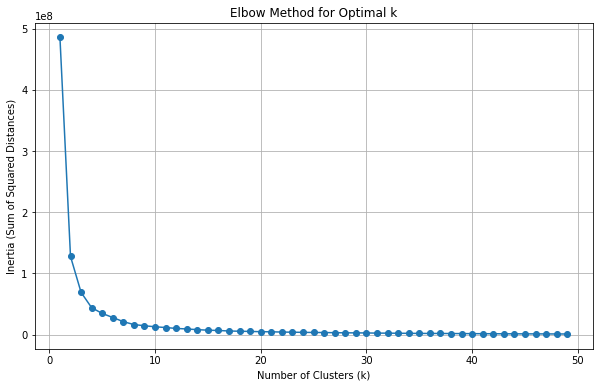

In [49]:
# Clustering based on geographical coordinates for challenge_set_updated

# Extract coordinates for adep and ades
adep_coords = challenge_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords = challenge_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Combine all coordinates for clustering
combined_coords = np.vstack((adep_coords, ades_coords))

# Calculate inertia for each k value in the specified range
inertia = []
k_range = range(1, 50)  # Testing cluster sizes from 1 to 50

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_coords)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
        
# Automatically determining the optimal k using the "elbow" point
# Finding the point where the reduction in inertia slows down significantly
optimal_k = 1  # Default to 1 cluster if no elbow is detected
threshold_ratio = 0.01  # Define a threshold for identifying the elbow point

# Checking for the point where inertia reduction starts to slow down
for i in range(1, len(inertia) - 1):
    if (inertia[i - 1] - inertia[i]) > (inertia[i] - inertia[i + 1]) * threshold_ratio:
        optimal_k = i + 1
        break

In [50]:
# Apply K-means clustering on combined coordinates
kmeans_geo = KMeans(n_clusters=20, random_state=42)  
kmeans_geo.fit(combined_coords)

# Assign cluster labels back to adep and ades separately
adep_geo_labels = kmeans_geo.predict(adep_coords)
ades_geo_labels = kmeans_geo.predict(ades_coords)

# Map cluster labels to the original dataframe
challenge_set_updated['adep_geo_cluster'] = adep_geo_labels
challenge_set_updated['ades_geo_cluster'] = ades_geo_labels

In [51]:
# Clustering based on geographical coordinates for submission_set_updated

# Extract coordinates for adep and ades from submission_set_updated
adep_coords_submission = submission_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords_submission = submission_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Assign cluster labels back to adep and ades separately for submission_set_updated
adep_geo_labels_submission = kmeans_geo.predict(adep_coords_submission)
ades_geo_labels_submission = kmeans_geo.predict(ades_coords_submission)

# Map cluster labels to the submission_set_updated dataframe
submission_set_updated['adep_geo_cluster'] = adep_geo_labels_submission
submission_set_updated['ades_geo_cluster'] = ades_geo_labels_submission

In [54]:
# List of categorical columns to analyze
categorical_columns = [
                    'aircraft_type', 
                    'wtc', 
                    'airline',
                    'offblock_hour',
                    'offblock_minute', 
                    'offblock_day_of_week',
                    'offblock_weekday_name',
                    'offblock_month',
                    'offblock_week_of_year', 
                    'offblock_season', 
                    'arrival_hour',
                    'arrival_minute',
                    'arrival_season',
                    'arrival_weekday_name',
                    'is_offblock_weekend',
                    'is_offblock_rush_hour',
                    'is_offblock_weekend',
                    'is_offblock_rush_hour',
                    'flight_duration_category',                       
                    'adep_region', 
                    'ades_region', 
                    'same_country_flight',
                    'same_region_flight',                        
                    'flight_direction',
                    'is_intercontinental',
                    'Manufacturer',
                    'Model_FAA',
                    'Physical_Class_Engine',
                    'FAA_Weight',
                    'adep_geo_cluster',
                    'ades_geo_cluster',
                    'Aircraft_Class']

# Calculate the number of unique values for each categorical column efficiently
unique_variations = challenge_set_updated[categorical_columns].nunique()

# Display the number of variations for each categorical variable
unique_variations

aircraft_type               30
wtc                          2
airline                     29
offblock_hour               24
offblock_minute             60
offblock_day_of_week         7
offblock_weekday_name        7
offblock_month              12
offblock_week_of_year       52
offblock_season              4
arrival_hour                24
arrival_minute              60
arrival_season               4
arrival_weekday_name         7
is_offblock_weekend          2
is_offblock_rush_hour        2
is_offblock_weekend          2
is_offblock_rush_hour        2
flight_duration_category     4
adep_region                  7
ades_region                  7
same_country_flight          2
same_region_flight           2
flight_direction             3
is_intercontinental          2
Manufacturer                 7
Model_FAA                   30
Physical_Class_Engine        2
FAA_Weight                   3
adep_geo_cluster            20
ades_geo_cluster            20
Aircraft_Class               3
dtype: i

In [55]:
# Function to rearrange the dataframe so that the target variable 'tow' is the last column
def rearrange_columns(df):
    # Moving 'tow' to the last position
    columns = [col for col in df.columns if col != 'tow'] + ['tow']
    df = df[columns]
    return df

# Remove some categorical columns
# new_columns_to_remove = ['date']
new_columns_to_remove = ['callsign','adep', 'ades', 'date']
challenge_set_updated = remove_columns(challenge_set_updated, new_columns_to_remove)
submission_set_updated = remove_columns(submission_set_updated, new_columns_to_remove)

# Apply One-Hot Encoding to the training set
challenge_set_updated = pd.get_dummies(challenge_set_updated, columns=categorical_columns, drop_first=True)

# Apply One-Hot Encoding to the test set
submission_set_updated = pd.get_dummies(submission_set_updated, columns=categorical_columns, drop_first=True)

# Align the test set columns with the training set columns
# Identify missing columns and create a DataFrame with those columns set to zero
missing_cols = set(challenge_set_updated.columns) - set(submission_set_updated.columns)
missing_cols_df = pd.DataFrame(0, index=submission_set_updated.index, columns=list(missing_cols))

# Concatenate the missing columns DataFrame with the test set
submission_set_updated = pd.concat([submission_set_updated, missing_cols_df], axis=1)

# Drop extra columns in the test set that are not in the training set
extra_cols = set(submission_set_updated.columns) - set(challenge_set_updated.columns)
submission_set_updated.drop(columns=list(extra_cols), inplace=True)

# Reorder the columns of the test set to match the training set
submission_set_updated = submission_set_updated[challenge_set_updated.columns]

# Rearrange columns
challenge_set_updated = rearrange_columns(challenge_set_updated)
submission_set_updated = rearrange_columns(submission_set_updated)

In [8]:
# Remove the columns that are in submission_set_updated but not in challenge_set_updated
common_columns = a.columns.intersection(b.columns)
submission_set_updated = submission_set_updated[common_columns]

# Reorder the columns to match the order in challenge_set_updated
submission_set_updated = submission_set_updated[challenge_set_updated.columns]

In [56]:
challenge_set_updated.to_csv('./data/challenge_set_updated_v19_xgboost.csv', index=False)
submission_set_updated.to_csv('./data/submission_set_updated_v19_xgboost.csv', index=False)